### Library Install

In [1]:
pip install missingno

Note: you may need to restart the kernel to use updated packages.


In [2]:
import pandas as pd
import numpy as np
import seaborn as sns
import matplotlib.pyplot as plt
import matplotlib
import warnings
import missingno as msno
from sklearn.preprocessing import StandardScaler
%matplotlib inline

sns.set_style('whitegrid')
sns.set(font_scale=1.0)
plt.style.use('seaborn-white')

### Data Load

In [3]:
# 데이터 합친 이후, 한번에 split_train_test 수행
def concat_df(train, test):
    apps= pd.concat([train, test]).reset_index(drop=True)
    return apps

def split_train_test(apps):
    train= apps[~apps['N_category'].isnull()]
    test= apps[apps['N_category'].isnull()]
    test.drop('N_category', axis=1)

    return train, test

In [4]:
# 데이터 불러오기
train = pd.read_csv("./open/train.csv")
test = pd.read_csv("./open/test.csv")

In [5]:
df = concat_df(train, test)

In [6]:
df.info()

<class 'pandas.core.frame.DataFrame'>
RangeIndex: 1250 entries, 0 to 1249
Data columns (total 28 columns):
 #   Column             Non-Null Count  Dtype  
---  ------             --------------  -----  
 0   ID                 1250 non-null   object 
 1   img_path           1250 non-null   object 
 2   mask_path          1000 non-null   object 
 3   나이                 1250 non-null   int64  
 4   수술연월일              1250 non-null   object 
 5   진단명                1250 non-null   int64  
 6   암의 위치              1250 non-null   int64  
 7   암의 개수              1250 non-null   int64  
 8   암의 장경              1168 non-null   float64
 9   NG                 1184 non-null   float64
 10  HG                 1148 non-null   float64
 11  HG_score_1         1140 non-null   float64
 12  HG_score_2         1140 non-null   float64
 13  HG_score_3         1143 non-null   float64
 14  DCIS_or_LCIS_여부    1250 non-null   int64  
 15  DCIS_or_LCIS_type  157 non-null    float64
 16  T_category         1245 

### EDA

<AxesSubplot:>

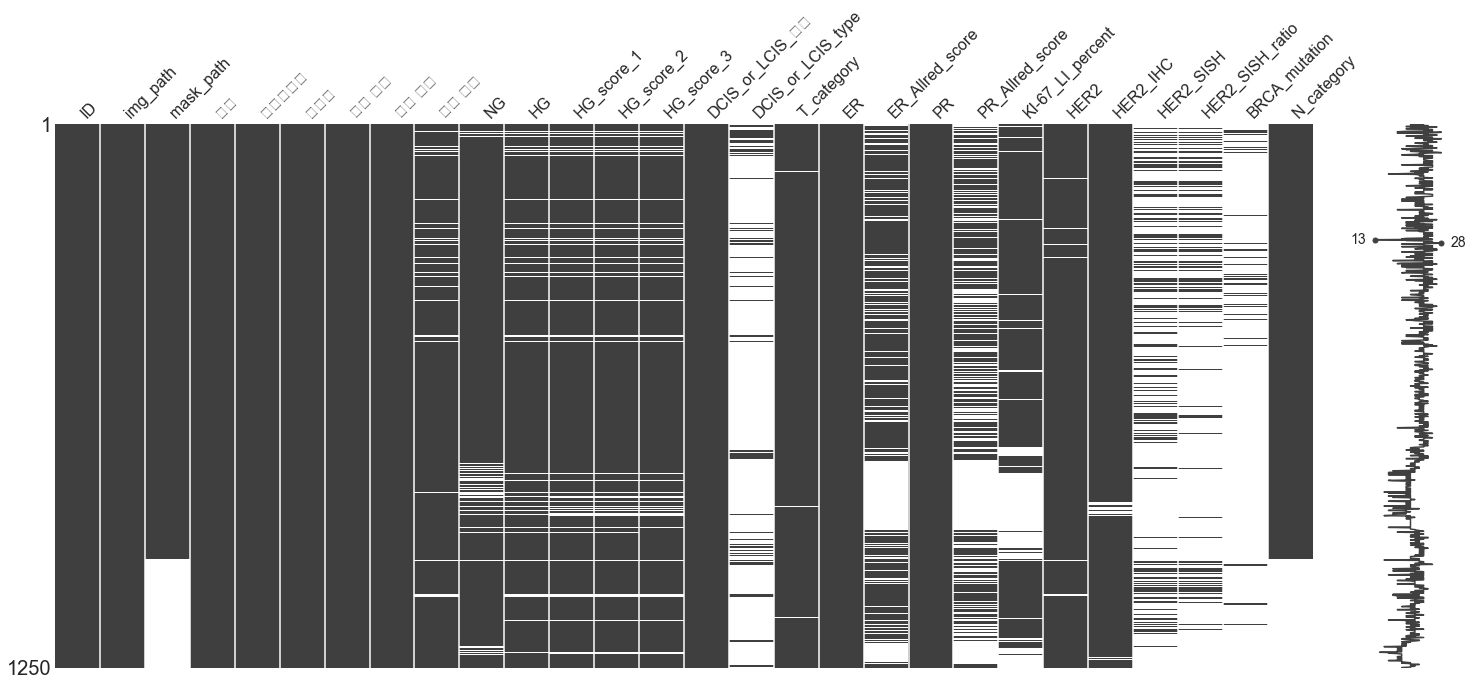

In [7]:
warnings.filterwarnings('ignore')
msno.matrix(df)

- 동일한 변수에 의해 결측치가 생긴 column 확인 "암의 장경", "NG", "HG", "HG_score_1", "HG_score_2", "HG_score_3"
- 동일한 변수에 의해 결측치가 반대로 발생한 column 확인 : "DCIS_or_LCIS_type" 
- 해당 변수를 파악하는 것이 EDA의 핵심이 될 것으로 예상

In [8]:
df["DCIS_or_LCIS_여부"].value_counts()

0    759
2    391
1    100
Name: DCIS_or_LCIS_여부, dtype: int64

In [9]:
df["DCIS_or_LCIS_type"].value_counts()

1.0    88
2.0    69
Name: DCIS_or_LCIS_type, dtype: int64

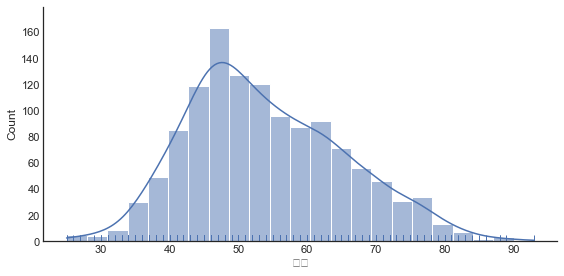

In [10]:
# 나이
warnings.filterwarnings('ignore')
sns.displot(df['나이'], kde=True, rug=True, height=4, aspect=2)

In [11]:
df["나이"].min()

25

In [12]:
df["나이"].describe()

count    1250.000000
mean       53.997600
std        11.430333
min        25.000000
25%        46.000000
50%        52.000000
75%        62.000000
max        93.000000
Name: 나이, dtype: float64

In [13]:
df.info()

<class 'pandas.core.frame.DataFrame'>
RangeIndex: 1250 entries, 0 to 1249
Data columns (total 28 columns):
 #   Column             Non-Null Count  Dtype  
---  ------             --------------  -----  
 0   ID                 1250 non-null   object 
 1   img_path           1250 non-null   object 
 2   mask_path          1000 non-null   object 
 3   나이                 1250 non-null   int64  
 4   수술연월일              1250 non-null   object 
 5   진단명                1250 non-null   int64  
 6   암의 위치              1250 non-null   int64  
 7   암의 개수              1250 non-null   int64  
 8   암의 장경              1168 non-null   float64
 9   NG                 1184 non-null   float64
 10  HG                 1148 non-null   float64
 11  HG_score_1         1140 non-null   float64
 12  HG_score_2         1140 non-null   float64
 13  HG_score_3         1143 non-null   float64
 14  DCIS_or_LCIS_여부    1250 non-null   int64  
 15  DCIS_or_LCIS_type  157 non-null    float64
 16  T_category         1245 

### NAN Data 채우기
> 암의 장경 : 암의 길이, NAN값을 해당 변수의 최솟값으로 대체
> - 모든 환자는 암이 존재하며, 길이가 작거나 위치가 좋지 않아 측정하기 어려운 것으로 예측

In [14]:
df["암의 장경"] = df["암의 장경"].fillna(0.1)
df["암의 장경"].isna().sum()

0

> ER_Allred_score : 에스트로겐 발현 스코어
> - 발현하지 않은 사람 180명에 대해 0으로 처리

In [15]:
df["ER_Allred_score"] = df["ER_Allred_score"].fillna(0)

In [16]:
df["ER_Allred_score"].isna().sum()

0

> PR_Allred_score : 프로게스테론 발현 스코어
> - 발현하지 않은 사람 453명에 대해 0으로 처리
> - 나머지 사람은 평균값으로 처리

In [17]:
for i in range(len(df['PR'])):
    if df['PR'][i] == 0 : 
        df['PR_Allred_score'] = 0
    elif df['PR_Allred_score'][i]==0:
        df['PR_Allred_score'] = df['PR_Allred_score'].fillna(df['PR_Allred_score'].mean())

In [18]:
df['PR_Allred_score'].isna().sum()

0

> KI-67_LI_percent : 세포증식의 수치를 표시한 항목
> - 평균으로 처리

In [19]:
df["KI-67_LI_percent"] = df["KI-67_LI_percent"].fillna(df["KI-67_LI_percent"].mean())

> 버릴 Column : DCIS_or_LCIS_type, HER2_SISH, HER2_SISH_ratio, BRCA_mutation
> - 사유 : 과반수 미만 Column, 범주형 데이터라 논리적 추측 불가

> 버릴 Column : ID, img_path, img_path, mask_path
> - 사유 : 불필요

In [20]:
# 버릴 column
warnings.filterwarnings('ignore')
df.drop(['ID', 'img_path', 'img_path','mask_path','DCIS_or_LCIS_type','HER2_SISH', 'HER2_SISH_ratio', 'BRCA_mutation'], 1, inplace = True)

In [21]:
df.info()

<class 'pandas.core.frame.DataFrame'>
RangeIndex: 1250 entries, 0 to 1249
Data columns (total 21 columns):
 #   Column            Non-Null Count  Dtype  
---  ------            --------------  -----  
 0   나이                1250 non-null   int64  
 1   수술연월일             1250 non-null   object 
 2   진단명               1250 non-null   int64  
 3   암의 위치             1250 non-null   int64  
 4   암의 개수             1250 non-null   int64  
 5   암의 장경             1250 non-null   float64
 6   NG                1184 non-null   float64
 7   HG                1148 non-null   float64
 8   HG_score_1        1140 non-null   float64
 9   HG_score_2        1140 non-null   float64
 10  HG_score_3        1143 non-null   float64
 11  DCIS_or_LCIS_여부   1250 non-null   int64  
 12  T_category        1245 non-null   float64
 13  ER                1249 non-null   float64
 14  ER_Allred_score   1250 non-null   float64
 15  PR                1249 non-null   float64
 16  PR_Allred_score   1250 non-null   int64  


### Scaling
> - StandardScaler 적용

In [22]:
def get_values(value):
    return value.values.reshape(-1, 1)

def scale_col(train, test, numeric_cols, ignore_cols):
    '''
    train : trainset dataframe
    test: testset dataframe
    numeric_cols: cols type int, float
    ignore_cols: clos type except int, float
    '''
    
    for col in train.columns:
        if col in ignore_cols:
            continue
        if col in numeric_cols:
            scaler= MinMaxScaler()
            train[col]= scaler.fit_transform(get_values(train[col]))
            test[col] = scaler.transform(get_values(test[col]))
#         else:
#             le = LabelEncoder()
#             train[col] = le.fit_transform(get_values(train[col]))
#             test[col] = le.transform(get_values(test[col]))
            
    return train, test

In [23]:
scaler = StandardScaler()
df["암의 장경"] = scaler.fit_transform(get_values(df["암의 장경"]))
df["ER_Allred_score"] = scaler.fit_transform(get_values(df["ER_Allred_score"]))
df["PR_Allred_score"] = scaler.fit_transform(get_values(df["PR_Allred_score"]))
df["KI-67_LI_percent"] = scaler.fit_transform(get_values(df["KI-67_LI_percent"]))

In [24]:
### Data export

In [25]:
df.info()

<class 'pandas.core.frame.DataFrame'>
RangeIndex: 1250 entries, 0 to 1249
Data columns (total 21 columns):
 #   Column            Non-Null Count  Dtype  
---  ------            --------------  -----  
 0   나이                1250 non-null   int64  
 1   수술연월일             1250 non-null   object 
 2   진단명               1250 non-null   int64  
 3   암의 위치             1250 non-null   int64  
 4   암의 개수             1250 non-null   int64  
 5   암의 장경             1250 non-null   float64
 6   NG                1184 non-null   float64
 7   HG                1148 non-null   float64
 8   HG_score_1        1140 non-null   float64
 9   HG_score_2        1140 non-null   float64
 10  HG_score_3        1143 non-null   float64
 11  DCIS_or_LCIS_여부   1250 non-null   int64  
 12  T_category        1245 non-null   float64
 13  ER                1249 non-null   float64
 14  ER_Allred_score   1250 non-null   float64
 15  PR                1249 non-null   float64
 16  PR_Allred_score   1250 non-null   float64


In [26]:
train_eda_exp1,test_eda_exp1 = split_train_test(df)

In [27]:
test_eda_exp1.info()

<class 'pandas.core.frame.DataFrame'>
Int64Index: 250 entries, 1000 to 1249
Data columns (total 21 columns):
 #   Column            Non-Null Count  Dtype  
---  ------            --------------  -----  
 0   나이                250 non-null    int64  
 1   수술연월일             250 non-null    object 
 2   진단명               250 non-null    int64  
 3   암의 위치             250 non-null    int64  
 4   암의 개수             250 non-null    int64  
 5   암의 장경             250 non-null    float64
 6   NG                235 non-null    float64
 7   HG                234 non-null    float64
 8   HG_score_1        232 non-null    float64
 9   HG_score_2        232 non-null    float64
 10  HG_score_3        232 non-null    float64
 11  DCIS_or_LCIS_여부   250 non-null    int64  
 12  T_category        249 non-null    float64
 13  ER                250 non-null    float64
 14  ER_Allred_score   250 non-null    float64
 15  PR                250 non-null    float64
 16  PR_Allred_score   250 non-null    float6

In [28]:
test_eda_exp1.drop(['N_category'], 1, inplace = True)

In [29]:
test_eda_exp1.info()

<class 'pandas.core.frame.DataFrame'>
Int64Index: 250 entries, 1000 to 1249
Data columns (total 20 columns):
 #   Column            Non-Null Count  Dtype  
---  ------            --------------  -----  
 0   나이                250 non-null    int64  
 1   수술연월일             250 non-null    object 
 2   진단명               250 non-null    int64  
 3   암의 위치             250 non-null    int64  
 4   암의 개수             250 non-null    int64  
 5   암의 장경             250 non-null    float64
 6   NG                235 non-null    float64
 7   HG                234 non-null    float64
 8   HG_score_1        232 non-null    float64
 9   HG_score_2        232 non-null    float64
 10  HG_score_3        232 non-null    float64
 11  DCIS_or_LCIS_여부   250 non-null    int64  
 12  T_category        249 non-null    float64
 13  ER                250 non-null    float64
 14  ER_Allred_score   250 non-null    float64
 15  PR                250 non-null    float64
 16  PR_Allred_score   250 non-null    float6

In [30]:
train_eda_exp1.to_csv('./train_eda_exp1.csv', index = False)

In [31]:
test_eda_exp1.to_csv('./test_eda_exp1.csv', index = False)

In [32]:
test_eda_exp1.columns

Index(['나이', '수술연월일', '진단명', '암의 위치', '암의 개수', '암의 장경', 'NG', 'HG',
       'HG_score_1', 'HG_score_2', 'HG_score_3', 'DCIS_or_LCIS_여부',
       'T_category', 'ER', 'ER_Allred_score', 'PR', 'PR_Allred_score',
       'KI-67_LI_percent', 'HER2', 'HER2_IHC'],
      dtype='object')

### Visualization

In [33]:
warnings.filterwarnings('ignore')
df_visual = df.drop(['수술연월일'], 1, inplace = False)

In [34]:
df_visual.info()

<class 'pandas.core.frame.DataFrame'>
RangeIndex: 1250 entries, 0 to 1249
Data columns (total 20 columns):
 #   Column            Non-Null Count  Dtype  
---  ------            --------------  -----  
 0   나이                1250 non-null   int64  
 1   진단명               1250 non-null   int64  
 2   암의 위치             1250 non-null   int64  
 3   암의 개수             1250 non-null   int64  
 4   암의 장경             1250 non-null   float64
 5   NG                1184 non-null   float64
 6   HG                1148 non-null   float64
 7   HG_score_1        1140 non-null   float64
 8   HG_score_2        1140 non-null   float64
 9   HG_score_3        1143 non-null   float64
 10  DCIS_or_LCIS_여부   1250 non-null   int64  
 11  T_category        1245 non-null   float64
 12  ER                1249 non-null   float64
 13  ER_Allred_score   1250 non-null   float64
 14  PR                1249 non-null   float64
 15  PR_Allred_score   1250 non-null   float64
 16  KI-67_LI_percent  1250 non-null   float64


In [35]:
#viz function

#x column's distplot
def show_dist_plot_x(columns,data):
    i = 0
    plt.figure(figsize=(24,16))
    plt.subplots(5,4,figsize=(24,16))
    for col in columns:
        i += 1
        plt.subplot(5,4,i)
        sns.distplot(data[col])
    plt.tight_layout()

#y column's distplot
def show_dist_plot_y(columns,data):
    i = 0
    plt.figure(figsize=(18,8))
    plt.subplots(2,7,figsize=(18,8))
    for col in columns:
        i += 1
        plt.subplot(2,7,i)
        sns.distplot(data[col],color='skyblue')
    plt.tight_layout()
    
#violinplot
def show_dist_plot_vio(columns,data):
    i = 0
    plt.figure(figsize=(24,16))
    plt.subplots(5,4,figsize=(24,16))
    for col in columns:
        i += 1
        plt.subplot(5,4,i)
        sns.boxplot(data = data[col],color='skyblue')
    plt.tight_layout()

#plot
def show_plot(data,columns):
    for col in columns:
        plt.figure(figsize=(36,12))
        plt.plot(data[col])
        plt.title(f'{col}', fontsize=40)
        plt.tight_layout()

<Figure size 1728x1152 with 0 Axes>

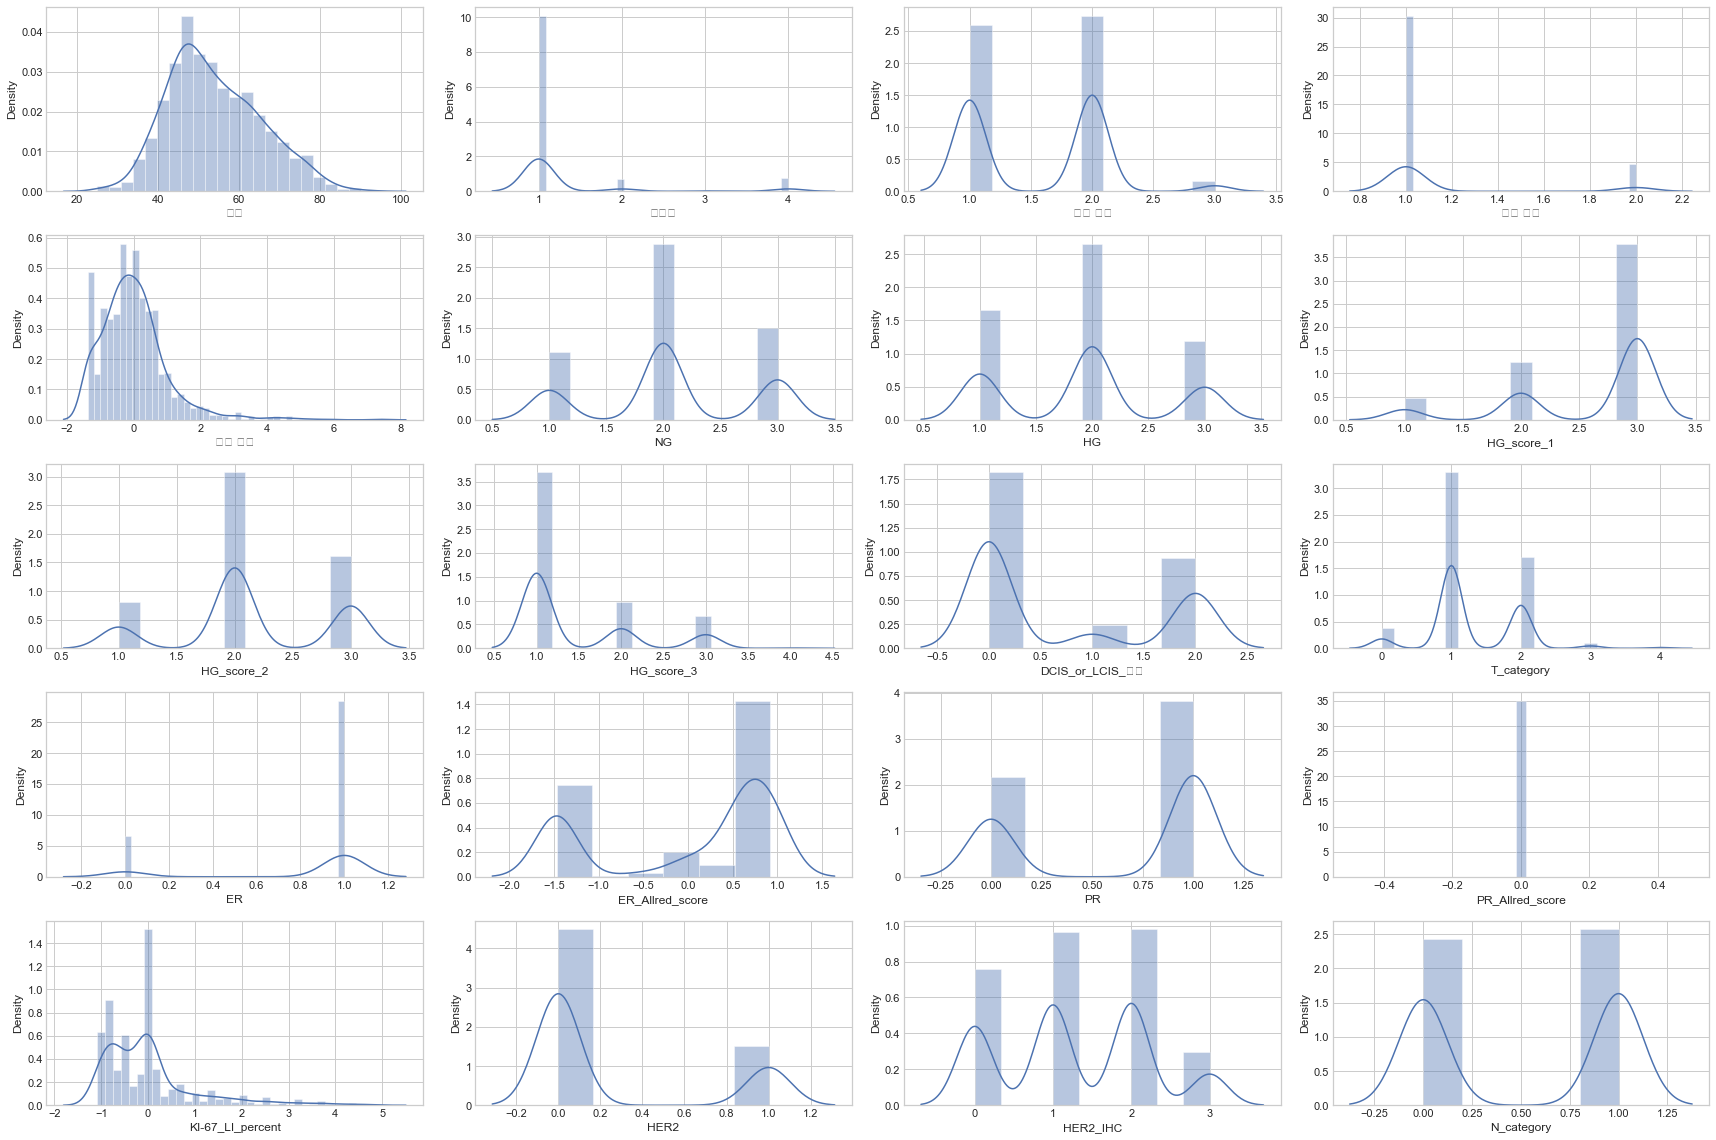

In [36]:
warnings.filterwarnings('ignore')
sns.set_style('whitegrid')
show_dist_plot_x(df_visual.columns, df_visual)

<Figure size 1728x1152 with 0 Axes>

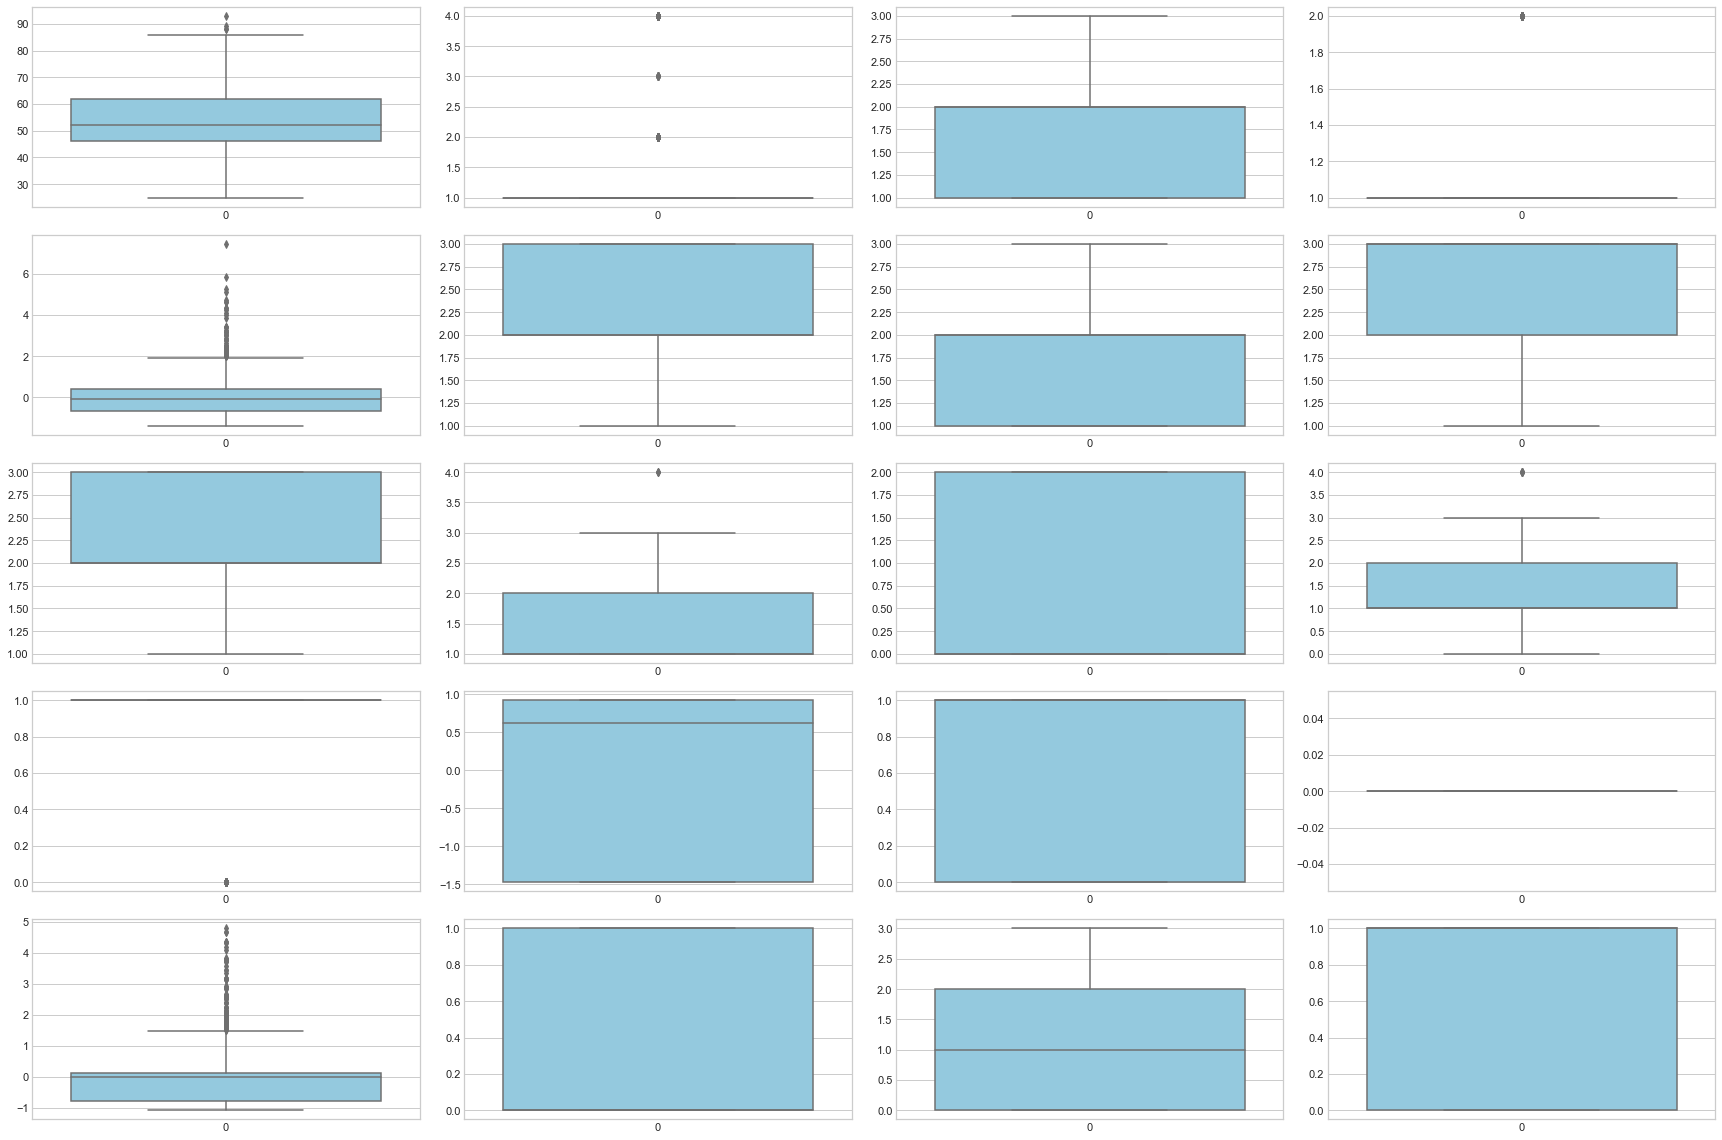

In [37]:
warnings.filterwarnings('ignore')
show_dist_plot_vio(df_visual.columns, df_visual)

In [38]:
df.info()

<class 'pandas.core.frame.DataFrame'>
RangeIndex: 1250 entries, 0 to 1249
Data columns (total 21 columns):
 #   Column            Non-Null Count  Dtype  
---  ------            --------------  -----  
 0   나이                1250 non-null   int64  
 1   수술연월일             1250 non-null   object 
 2   진단명               1250 non-null   int64  
 3   암의 위치             1250 non-null   int64  
 4   암의 개수             1250 non-null   int64  
 5   암의 장경             1250 non-null   float64
 6   NG                1184 non-null   float64
 7   HG                1148 non-null   float64
 8   HG_score_1        1140 non-null   float64
 9   HG_score_2        1140 non-null   float64
 10  HG_score_3        1143 non-null   float64
 11  DCIS_or_LCIS_여부   1250 non-null   int64  
 12  T_category        1245 non-null   float64
 13  ER                1249 non-null   float64
 14  ER_Allred_score   1250 non-null   float64
 15  PR                1249 non-null   float64
 16  PR_Allred_score   1250 non-null   float64


In [39]:
# train_eda_ver1,test_eda_ver1 = split_train_test(df)

In [40]:
# test_eda_ver1.drop(['N_category'], 1, inplace = True)

In [41]:
# train_eda_ver1.to_csv('./train_eda_ver1.csv', index = False)

In [42]:
# test_eda_ver1.to_csv('./test_eda_ver1.csv', index = False)

In [43]:
# test_eda_ver1.info()